# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182249,app_3773_5546_phnd_pos_0054.wav,172.265625,1198,99.833333,0.620618,0.070292,0.381610,0.081022,0.239084,0.026172,...,-5.338770,81.940697,-5.307585,102.843636,2.587634,59.694859,-6.465442,90.452126,-5.180311,69.693237
182250,app_3773_5546_phnd_pos_0055.wav,78.302557,306,76.500000,0.612606,0.070161,0.402439,0.081770,0.242212,0.024667,...,-6.690513,108.272583,-5.633468,85.068466,3.843521,61.155022,-6.021213,80.570854,-3.540390,73.617676
182251,app_3773_5546_phnd_pos_0056.wav,112.347147,1380,125.454545,0.635446,0.060374,0.389387,0.085514,0.236210,0.027538,...,-7.048096,96.782806,-5.787949,78.352753,-1.718377,59.865887,-5.130420,64.361443,-3.386290,50.095055
182252,app_3773_5546_phnd_pos_0057.wav,198.768029,2364,118.200000,0.627674,0.065552,0.396143,0.079859,0.244746,0.023433,...,-8.338559,100.234261,-5.238555,83.026726,-3.655035,84.823341,-5.556218,57.476173,-0.247402,50.155182


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [6]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state=None):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# Q1

In [7]:
def FNN():
    model = Sequential([
        Dense(128, activation="relu", input_shape=(77,)),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    adamOptimizer = tf.keras.optimizers.Adam(0.001)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
    model.compile(optimizer=adamOptimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model = FNN()

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(X_train_scaled, y_train, 
                    epochs=100, 
                    batch_size=256, 
                    verbose = 'auto', 
                    use_multiprocessing=True,
                    callbacks=[callback],
                    validation_data=(X_test_scaled, y_test))


Epoch 1/100
499/499 [==============================] - 2s 3ms/step - loss: 0.6897 - accuracy: 0.5362 - val_loss: 0.6845 - val_accuracy: 0.5547
Epoch 2/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6834 - accuracy: 0.5520 - val_loss: 0.6810 - val_accuracy: 0.5583
Epoch 3/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.5606 - val_loss: 0.6799 - val_accuracy: 0.5618
Epoch 4/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5656 - val_loss: 0.6767 - val_accuracy: 0.5681
Epoch 5/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5737 - val_loss: 0.6728 - val_accuracy: 0.5760
Epoch 6/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6705 - accuracy: 0.5792 - val_loss: 0.6703 - val_accuracy: 0.5808
Epoch 7/100
499/499 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.5851 - val_loss: 0.6674 - val_accuracy: 0.5895

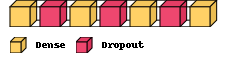

In [9]:
#model.summary()

import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True) 

# Q1b

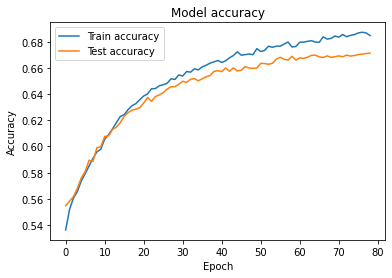

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])

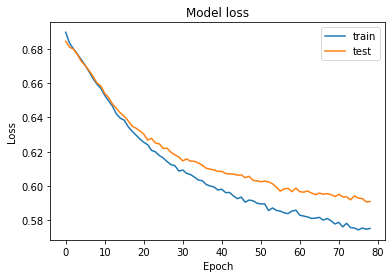

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])

### Comments
Accuracies from both train and test increases every epoch, while the loss from the training and test decreases. <br>
As the loss decreases, the accuracy increases. <br>
Training accuracies are generally higher than test accuracies because model is optimized for the training set. <br>
Early stopping is used to avoid overfitting.

# Q2

In [12]:
class TimeCallBack(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []
        
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score

batch_sizes = [128, 256, 512, 1024]
cv_scores = {}

for i in batch_sizes:
    batch = {}
    kfold_model = KerasClassifier(build_fn=FNN, 
                                  epochs=100, 
                                  batch_size=i, 
                                  verbose=0)

    start = time.time()

    acc = cross_val_score(kfold_model, X_train_scaled, y_train, cv=5)

    end = time.time()
    batch['acc'] = acc
    batch['time'] = end - start
    cv_scores[i] = batch

C:\Users\umer2\AppData\Local\Temp/ipykernel_7012/311917625.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  kfold_model = KerasClassifier(build_fn=FNN,


# Q2a

In [ ]:
mean_cv_acc = []

for i in cv_scores:
    mean = 0
    for j in cv_scores[i]['acc']:
        mean += j
    mean /= 5
    mean_cv_acc.append(mean)
    
plt.scatter(batch_sizes, mean_cv_acc)
plt.title('Final epoch mean cross-validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Batch sizes')

# Q2b

In [ ]:
final_epoch_time = []

for i in cv_scores:
    final_epoch_time.append(cv_scores[i]['time']/100)
    
d = {
    'batch size': batch_sizes,
    'final epoch timing': final_epoch_time
}
df_batch = pd.DataFrame(data=d)
df_batch

# Q2c

256 is the optimal batch size, because it has the highest accuracy with a slightly higher training time.

In [ ]:
BATCH_OPTIMAL = 256

# Q2d

When the batch size increases, the training time decreases. This happens because when one batch is large, there are lesser iterations needed in one epoch to complete, thus reducing the time taken to train a large batch.

# Q2e

The batch size happens to match the model trained in Q1a. As such, the results are retrieved directly from Q1a.

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])

# Q3a

In [ ]:
neuron_count = [64, 128, 256]
mean_cv_acc = []

kfold = KFold(n_splits=5, shuffle=True)


for i in neuron_count:    
    model = Sequential([
        Dense(i, activation="relu", input_shape=(77,)),
        Dropout(0.2),
        Dense(i, activation="relu"),
        Dropout(0.2),
        Dense(i, activation="relu"),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])

    adamOptimizer = tf.keras.optimizers.Adam(0.001)

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    
    model.compile(optimizer=adamOptimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    k_split_acc = 0
    for train, test in kfold.split(X_train_scaled, y_train):      
        hi = model.fit(X_train_scaled[train], y_train[train], 
                    epochs=100, 
                    batch_size=BATCH_OPTIMAL, 
                    verbose = 'auto', 
                    use_multiprocessing=True,
                    callbacks=[callback],
                    validation_data=(X_train_scaled[test], y_train[test]))
        k_split_acc += hi.history['accuracy'][0]
    
    k_split_acc /= 5
    mean_cv_acc.append(k_split_acc)
    
mean_cv_acc


In [ ]:
plt.scatter(neuron_count, mean_cv_acc)
plt.title('Final epoch mean cross-validation accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Hidden layer size')

# Q3b

256 neurons. It gave the highest accuracy for the 5 fold cross validation

In [ ]:
NEURAL_OPTIMAL = 256

# Q3c

In [ ]:
model = Sequential([
    Dense(NEURAL_OPTIMAL, activation="relu", input_shape=(77,)),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu"),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

adamOptimizer = tf.keras.optimizers.Adam(0.001)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer=adamOptimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

optimal = model.fit(X_train_scaled, y_train, 
                epochs=100, 
                batch_size=BATCH_OPTIMAL, 
                verbose = 'auto', 
                use_multiprocessing=True,
                callbacks=[callback],
                validation_data=(X_test_scaled, y_test))

In [ ]:
plt.plot(optimal.history['accuracy'])
plt.plot(optimal.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])

# Q3d

Dropout is a technique that helps prevent overfitting. It randomly sets a fraction of input units to 0 at each step during training time, which will cause that neuron to be ignored during training. <br>
Inputs not dropped are scaled up by a certain factor to match the dimensions required.

# Q3e
Using regularisation. Regularisation removes certain features. Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the loss function. Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. This helps overfitting because the model is able to better generalise the relationship between the inputs and outputs

In [ ]:
from tensorflow.keras import regularizers

model = Sequential([
    Dense(NEURAL_OPTIMAL, activation="relu", input_shape=(77,)),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu", kernel_regularizer=regularizers.L2(0.01)),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

adamOptimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=adamOptimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

hi = model.fit(X_train_scaled, y_train, 
                epochs=100, 
                batch_size=BATCH_OPTIMAL, 
                verbose = 'auto', 
                callbacks=[callback],
                use_multiprocessing=True,
                validation_data=(X_test_scaled, y_test))

plt.plot(hi.history['accuracy'])
plt.plot(hi.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'])

# Q4a

In [ ]:
df_q4 = pd.read_csv('./new_record.csv') 
df_q4['label'] = df_q4['filename'].str.split('_').str[-2]
columns_to_drop = ['label','filename']

label_encoder = preprocessing.LabelEncoder()
df_q4['label'] = label_encoder.fit_transform(df_q4['label'])

q4_labels = df_q4['label'].to_numpy()
df_q4_dropped = df_q4.drop(columns_to_drop,axis=1)


standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit_transform(X_train)
df_q4_scaled = standard_scaler.transform(df_q4_dropped)

df_q4_scaled

# Q4b

In [ ]:
model = Sequential([
    Dense(NEURAL_OPTIMAL, activation="relu", input_shape=(77,)),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu"),
    Dropout(0.2),
    Dense(NEURAL_OPTIMAL, activation="relu"),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

adamOptimizer = tf.keras.optimizers.Adam(0.001)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer=adamOptimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

optimal = model.fit(X_train_scaled, y_train, 
                epochs=100, 
                batch_size=BATCH_OPTIMAL, 
                verbose = 'auto', 
                use_multiprocessing=True,
                callbacks=[callback],
                validation_data=(X_test_scaled, y_test))

In [ ]:
if model.predict(df_q4_scaled) > 0.5:
    prediction = 'Positive'
else:
    prediction = 'Negative'
    
prediction

# Q4c

In [ ]:
import shap
from sklearn import tree

# compute SHAP values
explainer = shap.DeepExplainer(model, X_train_scaled)
shap_values = explainer.shap_values(df_q4_scaled)

shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = df_q4_dropped.columns)

# Conclusion

